# ディープラーニングの実行

-----------------
## ①各種ライブラリの読み込み

### ①－１：乱数の影響を受けるライブラリの読み込みとシード指定
まずは乱数の影響を受ける恐れのあるライブラリ群を読み込みます。<br>
各種ライブラリの乱数シードも忘れずに指定しておきましょう。<br>
乱数シードを指定したにも関わらず、再現性が得られない場合もありますので、学習時にモデルの保存を忘れないようにしましょう。<br>
残念ながら、ここで紹介している例では再現性が得られませんでした。<br>
読者の皆さんが試した際に同じ結果が得られない点はご了承ください。<br>

<ul>
    <li>データ整形　・・・ numpy </li>
    <li>ディープラーニングフレームワーク ・・・　tensorflow </li>
    <li>乱数 ・・・ random  </li>
    <li>OS（オペレーティングっステム）に依存した機能の利用　・・・ os
    <li>ディープラーニングフレームワーク（ラッパーライブラリ） ・・・　keras.backend</li>
</ul>

In [1]:
#---------------------------------------
#  各種ライブラリの読み込み①
#---------------------------------------
import numpy as np
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123) # 乱数を使う場合、再現性を保つためSEEDを指定
rn.seed(123)

session_conf = tf.ConfigProto(intra_op_parallelism_threads = 1, \
                              inter_op_parallelism_threads = 1)
from keras import backend as K
tf.set_random_seed(123)
sess = tf.Session(graph = tf.get_default_graph(), config = session_conf)
K.set_session(sess)

Using TensorFlow backend.
C:\Users\s-ohashi\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### ①－２：その他の必要ライブラリの読み込み
乱数の影響を受けないライブラリを順に読み込みます。<br>
<ul>
    <li>データ整形　・・・ pandas </li>
    <li>可視化 ・・・ matplotlib.pyplot </li>
    <li>モデル定義 ・・・　keras.moels.Sequential</li>
    <li>ネットワークの層（部品） ・・・　keras.layers.Dense, keras.layers.Dropout</li>
    <li>最適化アルゴリズム ・・・　keras.optimizers.Adam</li>
    <li>コールバック（最適化中に実行する処理） ・・・　keras.callbacks.LearningRateScheduler, keras.callbacks.EarlyStopping, keras.callbacks.ModelCheckpoint</li>
    <li>モデルの読み込み ・・・　keras.models.load_model</li>
    <li>機械学習の結果評価 ・・・ sklearn.metrics.confusion_matrix </li>
</ul>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential     # ネットワーク構造定義に利用
from keras.layers import Dense, Dropout # ネットワークの部品
from keras.optimizers import Adam       # 最適化アルゴリズム
# fit中に利用
from keras.callbacks import LearningRateScheduler,EarlyStopping, ModelCheckpoint
from keras.models import load_model          # モデルの読み込み用
from sklearn.metrics import confusion_matrix # 混同行列作成用

----------
## ②データの取り込み、データ分割

### ②－１：データの取り込み
文字列を含む項目があるため、pandasを使いデータを取り込みます。<br>
csv形式のデータなので、read_csvを使って取り込みましょう。

In [3]:
#---------------------------------------
#  データの取り込み、データ分割②
#---------------------------------------
df = pd.read_csv("car_braking.csv")

### ②－２：データの分割
scikit-learnが提供するtrain_test_split関数でも良いですが、ここではnumpyを活用した例を紹介します。<br>
データを学習、検証、評価に６対２対２の比率で分割します。<br>
そのためにまず全体のレコード数をlen(df)で求め、そこに各データの比率を掛けて、それぞれのデータ件数を求めます。<br>
intで囲っているのは、レコード件数を整数にするためです。これをキャスティングといいます。<br>
np.random.permutationを使って作られたperm_idxはランダムに並び替えられたインデックス値になります。<br>
perm_idxを前から順に6割、2割、2割とデータを取得すると、無作為抽出（ランダムサンプリング）されたデータセットができます。

In [4]:
train_num = int( len(df) * 0.6 ) # 6割を学習データ
val_num = int( len(df) * 0.2 )   # 2割を検証データ

perm_idx = np.random.permutation( len(df) ) # ランダムなインデックス
# perm_idxの先頭から6割までを学習用インデックスにする
train_idx = perm_idx[ : train_num ]
# perm_idxの先頭6割から8割までを検証用のインデックスにする
val_idx = perm_idx[ train_num : (train_num + val_num) ]
# perm_idxの先頭8割以降をテスト用のインデックスにする
test_idx = perm_idx[ (train_num + val_num) : ]

train_df = df.iloc[ train_idx, : ] # 学習用インデックス値で行抽出
val_df = df.iloc[ val_idx, : ]     # 検証用インデックス値で行抽出
test_df = df.iloc[ test_idx, : ]   # テスト用インデックスで行抽出

--------
## ③教師ラベルの加工
ここでは分類問題を考えますが、データにはブレーキを踏む・踏まないという教師ラベルがありません。<br>
停止距離(measured_braking_distance)がデータ上にあるので、この値と前方物体までの距離を比較して教師ラベルを作ります。<br>
ブレーキを踏む場合は１、踏まない場合は０とします。<br>
1サンプルにつき物体までの距離を5パターン用意します。<br>

### ③－１：教師ラベル作成用の関数作成
データを格納するための空のデータフレーム(container_df)を作ります。<br>
pd.DataFrameでデータフレームを呼び出し、その後ろにdictionary形式で変数名と空のリストを与えます。<br>
{　変数名1:[], 変数名2:[] }といった具合です。<br><br>
次に、説明変数として使う項目をリスト形式でデータフレームに与えます。<br>
このデータフレームをtemp_dfとします。<br><br>
続いて、物体までの距離の生成するためにnp.random.uniformを使い一様分布の乱数を生成します。<br>
この乱数を使い、停止距離の50%から150%の範囲で物体まで距離を生成します。<br><br>
停止距離と物体までの距離の大小関係から教師ラベルを作ります。<br>
物体までの距離（distance_to_object）と教師ラベル(hit_brake)をtemp_dfのデータフレームに追加します。<br><br>
container_dfにtemp_dfを追加します。<br><br>
この一連の処理を引数に与えているsamplesの回数だけ繰り返します。<br>

In [5]:
#---------------------------------------
#  教師ラベルの加工③
#---------------------------------------
# ここでは分類問題として考える。
# 車重、車速、タイヤ幅、路面、物体までの距離を与えたときに、
# ブレーキを踏む必要があるかを判定するロジックを作る。
# 教師ラベルはブレーキを踏む場合１、踏まない場合は０とする。
# 0と１の教師ラベルを停止距離(measured_braking_distance)と
# 乱数生成で作った物体までの距離で作る
# 1サンプルにつき、物体までの距離が異なるサンプルを5個作る
# 停止距離<=物体までの距離のときブレーキを踏むとする。

def create_label( samples, input_df ):
    # samplesは、１計測結果につき作るサンプル数。この例では5。
    # input_dfは、入力するデータフレーム
    
    # 空のデータフレームのコンテナを作成。ここにデータを足していく。
    container_df = pd.DataFrame( {'car_weight'         : [], # 車重
                                  'car_velocity'       : [], # 車速
                                  'tire_width'         : [], # タイヤ幅
                                  'road_type'          : [], # 路面
                                  'distance_to_object' : [], # 物体までの距離
                                  'hit_brake'          : []} ) # ブレーキ要否
    for i in range(samples):
        temp_df = input_df[ ['car_weight', 'car_velocity', \
                            'tire_width', 'road_type'] ] #列指定
        # 停止距離の50%～150%でサンプルを作る。
        # numpyのuniform関数で一様分布の乱数を生成して、停止距離に掛ける。
        random_distance = input_df['measured_braking_distance'] \
                          * np.random.uniform( 0.5, 1.5, len(input_df) )
        # 停止距離がランダムな距離以下の時１、そうでない場合は0とする。
        # これを教師ラベルとする。
        # リストにif-else処理をして、別のリストを作る方法
        # [TRUE時の処理 if 条件 else FALSE時の処理 for文]
        labels = [ 1. if \
                        (input_df['measured_braking_distance']).iloc[j] \
                        <= random_distance.iloc[j] \
                      else \
                        0. \
                      for j in range( len(input_df) ) ]
        # ランダムな距離をデータフレームに格納
        temp_df['distance_to_object'] = random_distance
        # ラベルをデータフレームに格納
        temp_df['hit_brake'] = labels
        # データをコンテナのデータフレームに追加
        container_df = pd.concat([container_df, temp_df])
    return container_df

### ③－２：学習、検証、評価データに教師ラベル作成用の関数を適用
教師ラベル作成用の関数を各データセットに適用します。<br>
1サンプルにつき物体までの距離を5パターン用意するので、一つ目の引数を5にしています。<br>
こうして作られるtrain_df2, val_df2, test_df2は説明変数と目的変数（教師ラベル）の両方を含んでいるため、目的変数を別変数として取り出しておきます。<br>
なお、命名する際は説明変数となるものにxを、目的変数となるものにｙをつけるのが慣例です。

In [6]:
# 学習、検証、テストデータの各サンプルについて5個教師ラベルを作る
train_df2 = create_label(5, train_df)
val_df2 = create_label(5, val_df)
test_df2 = create_label(5, test_df)

train_y = np.array(train_df2['hit_brake'])
val_y = np.array(val_df2['hit_brake'])
test_y = np.array(test_df2['hit_brake'])

-----------------
## ④カテゴリ変数をダミー変数に変換

カテゴリ変数とは、通常の変数とは違い連続値ではなく離散値の説明変数です。<br>
この例のように文字列だけでなく、数値もカテゴリ変数になりえます。<br>
例えば、店舗コードなどは数字で記録されますが、数値の大小関係に意味はないためカテゴリ変数として扱うのが適切です。<br>
こういった説明変数を扱う際は、ダミー変数化をします。<br>
ダミー変数化すると、元々の説明変数を除外し、代わりに説明変数のユニーク値が項目になります。<br>
路面状態のユニーク値は３つあるため、ダミー変数を２つ用意すれば元データと同じ情報となります。<br>
※3つ目のユニーク値については、1つ目か2つ目かの情報があれば消去法で判断できるため不要

●元データ

|road_type|
|---|
|snow_road| 
|tarmac_dry|
|snow_road| 
|tarmac_wet|
|...| 
<br>

●ダミー変数化後

|snow_road|tarmac_dry|
|---|
|1|0| 
|0|1|
|1|0|
|0|0|
|...|...| 


### ④－１：ユニーク値の確認
ユニーク値の件数（同一の値の重複を取り除いた状態での件数）を確認します。<br>
np.unique()を使うことで重複を取り除き、ユニーク値を得ることができます。<br>

In [7]:
#---------------------------------------
#  カテゴリ変数をダミー変数に変換④
#---------------------------------------
# カテゴリ変数であるroad_type変数のユニーク値を調べる
unique_road_type = np.unique(df['road_type'])
print ("-unique road type------------------")
print(unique_road_type)

-unique road type------------------
['snow_road' 'tarmac_dry' 'tarmac_wet']


### ④－２：空のダミー変数の作成
ダミー変数はユニーク値が多くない場合は、ユニーク値－1です。<br>
ダミー変数の行数は元々のデータと同じなので、len()を使って件数を取得します。<br>
np.zerosですべての値が0の行列を作ります。<br>

In [8]:
# ダミー変数の数はダミー変数は（ユニーク値の数）-1になる。
# ユニーク値が多い場合は、「その他」にまとめるなどの工夫が必要だが、
# 今回は少ないためそのような対応は不要
dummy_cat_num = len(unique_road_type)-1 #ダミー変数の数
# 空のダミー変数を作成。この後のダミー変数化の処理で値を入れていく。
# np.zeros()はからの行列を作る。引数に行列の大きさを与える。
# 行数は学習、検証、テストデータの行数、列は（ユニーク値の数）-1
train_dummy_vars = np.zeros( (len(train_df2), dummy_cat_num) )
val_dummy_vars = np.zeros( (len(val_df2), dummy_cat_num) )
test_dummy_vars = np.zeros( (len(test_df2), dummy_cat_num) )

### ④－３：ダミー変数化
ダミー変数毎に以下の処理をします。<br>
元のデータの路面状態(road_type)を確認して、値が０か１かを判断して④－２で作ったからのダミー変数に反映させます。

In [9]:
# ダミー変数化
for i in range(dummy_cat_num): # ダミー変数の数だけループ
    this_road_type = unique_road_type[i] # ダミー変数化する路面を選択
    # 学習、検証、テストデータ上の路面が、今ダミー変数化したい路面だった場合に１、
    # そうでない場合に0にする。
    train_dummy_vars[:, i] = [ 1. if road_type == this_road_type else 0.\
                    for road_type in train_df2['road_type'] ] 
    val_dummy_vars[:, i] = [ 1. if road_type == this_road_type else 0. \
                  for road_type in val_df2['road_type']] 
    test_dummy_vars[:, i] = [ 1. if road_type == this_road_type else 0. \
                   for road_type in test_df2['road_type'] ] 

-----------------
## ⑤標準化
標準化とは、説明変数の平均を０にして、標準偏差を１にする処理です。<br>
機械学習のアルゴリズムの中には、説明変数毎にとる値の範囲が違いすぎると、学習が上手くいかないものがあります。<br>
このため、どの説明変数を見ても平均が０で標準偏差が１になるようにするのが良いとされます。<br>

### ⑤－１：平均と標準偏差の算出と保存
モデルを使うのに必要な説明変数のうち連続値であるものを取得します。<br>
学習データで、これら説明変数の平均と標準偏差を算出します。<br>
ここで求めた平均と標準偏差は後々必要なため、np.saveを使って保存しておきます。

In [10]:
train_x = np.array(train_df2[ ['car_weight', 'car_velocity', 'tire_width',\
                              'distance_to_object'] ]) # 連続値取得
mean_x = np.mean(train_x, axis = 0)
std_x = np.std(train_x, axis = 0)
np.save('mean_x.npy', mean_x) # 平均値の保存
np.save('std_x.npy', std_x)   # 標準偏差の保存

### ⑤－２：標準化処理
学習、検証、テストデータのそれぞれから⑤－１で求めた平均を引き、⑤－１で求めた標準偏差で割ります。

In [11]:
train_x -= mean_x #平均0
train_x /= std_x  #標準偏差1
train_x = np.hstack([train_x, train_dummy_vars]) # 連続値とダミー変数のマージ

val_x = np.array(val_df2[ ['car_weight', 'car_velocity', 'tire_width',\
                          'distance_to_object'] ]) # 連続値取得
val_x -= mean_x # 平均0
val_x /= std_x  # 標準偏差1
val_x = np.hstack([val_x, val_dummy_vars]) # 連続値とダミー変数のマージ

test_x = np.array(test_df2[ ['car_weight', 'car_velocity', 'tire_width',\
                            'distance_to_object'] ]) # 連続値取得
test_x -= mean_x # 平均0
test_x /= std_x  # 標準偏差1
test_x = np.hstack([test_x, test_dummy_vars]) # 連続値とダミー変数のマージ

-----------------
##  ⑥ネットワーク構造の定義、モデルのコンパイル
チューニング処理でモデルを何度も作り直すことになるので、モデルを作る関数を作っています。<br>
モデルのハイパーパラメータは各層のユニット数として、関数の引数pで与えています。<br>
関数内では、まずモデルを作るためにSequentialオブジェクトを作ります。<br>
このモデルに層を追加後、コンパイルしてモデルが使える状態になります。<br>
モデルに層を追加するためには.add()メソッドを使います。<br>
ここでは最も基本的な層である全結合層Dense()を使っています。<br>
Denseの引数でユニット数や活性化関数（activation）を指定しますが、一層目の層のみ追加で入力データの項目数(input_shape)の指定が必要です。<br>
層と層の間にDropout()を入れると過学習が抑制できるので、ここでは追加することにしました。<br><br>

モデルをコンパイルするには、.compile()メソッドを呼び出します。<br>
重要な引数はloss、metrics、optimizerです。<br>

In [12]:
def model_create_compile(p): # pは各層のユニット数が記録されたリスト
    model = Sequential() # 以降、モデルにaddで層を追加
    
    # p[0]から1層目のユニット数を取得、活性化関数はrelu
    # 最初の隠れ層はinput_shapeの指定が必要
    model.add(  Dense( p[0], activation='relu' ,input_shape=(6,) )  ) 
    #過学習を抑えて、精度を向上させるために追加
    model.add( Dropout(0.5) )
    
    # p[1]から2層目のユニット数を取得。p[1]が0より大きい場合、2層目作成処理。
    # 2層目からはinput_shapeの指定が不要
    if p[1] > 0:
        model.add( Dense(p[1], activation='relu') )
        model.add( Dropout(0.5) )
        # p[2]から3層目のユニット数を取得。p[2]が0より大きい場合、3層目作成処理。
        if p[2] > 0:
            model.add( Dense(p[2], activation='relu') )
            model.add( Dropout(0.5) )
    # 出力層の作成
    # ブレーキを踏む確率を出力させたいため、ユニット数１で活性化関数はシグモイド
    # これで0~1の値を出力するモデルが作れる
    model.add(Dense(1, activation='sigmoid'))
    
    # モデルは、コンパイルしないと使えないため注意
    # 損失関数をbinary_crossentropyを指定
    # metricで正解率を確認するためにaccを指定
    # 最適化アルゴリズムはAdamを使用
    model.compile( loss='binary_crossentropy', metrics=['acc'], optimizer=Adam() ) 
    
    return model

### ⑦学習の設定と実行
ディープラーニングでは一部のデータを用い、モデルを段階的に更新していきます。<br>
この際、一回の更新でどの程度パラメータを変更するかを決めるのが学習率(learning rate)です。<br>
学習率の値は最初は大きめにして徐々に低下させていくのが一般的ですので、これをstep_decay()関数で定義しています。<br><br>

次に、学習をするため一連の処理をfit_and_checkpoint()関数に定義します。<br>
1エポック終わるごとに実行される処理（callbacks）は三つ指定します。
<ul>
    <li>LearningRateScheduler
        <ul>
            <li>先ほど定義したstep_decay()関数を使って、学習率を変化させます。</li>
            <li>LearningRateScheduler()の引数にstep_decayを与えます。</li>
        </ul>
    </li>
    <li>EarlyStopping
        <ul>
            <li>学習処理の打ち切り設定です。</li>
            <li>検証データでの損失値（val_loss）が30エポック改善しないとき打ち切るようにしています。</li>
        </ul>
    </li>
    <li>ModelCheckpoint
        <ul>
            <li>学習の途中でよいモデルが見つかった際にモデルを保存しておくのに使います。</li>
            <li>検証データでの損失値（val_loss）がこれまでで最もよいモデルを都度保存するようにします。</li>
            <li>filepathで保存先と保存する名前を指定します。</li>
        </ul>
    </li>
</ul>



In [13]:
#---------------------------------------
#  学習の設定と実行⑦
#---------------------------------------
# 学習率のスケジュラーに必要な関数を定義する
def step_decay(epoch):
    init_lr = 1.e-2     # 初期の学習率
    if epoch >= 20:
        init_lr = 1.e-3 # 20エポック後の学習率
    if epoch >= 40:
        init_lr = 1.e-4 # 40エポック後の学習率
    if epoch >= 60:
        init_lr = 1.e-5 # 60エポック後の学習率
    return init_lr

def fit_and_checkpoint(model):
    # 最適化する際に用いる学習率を定期的に下げていくのが一般的。
    # ここでstep_decayをスケジュラーとして指定。
    lr_decay = LearningRateScheduler(step_decay)
    
    # ディープラーニングでは学習をやめるタイミングが重要。EarlyStopという。
    # ここでは30epoch待ってもval_lossが改善しない場合、処理を中断する。
    early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    
    # ディープラーニングでは学習を進めるほど良いとは限らないため、
    # このネットワーク構造での暫定ベストモデルを記録する。
    model_cp = ModelCheckpoint(filepath = 'dl_model.h5' , monitor='val_loss', \
                               verbose=0, save_best_only=True, mode='auto')
    # fit()でフィッティング。historyには、epoch毎の結果が格納されるが、ここでは使わない。
    history = model.fit(train_x, train_y,
                        batch_size=512, # バッチサイズ。モデルを1度更新する際に利用するサンプル数。
                        epochs=300,     # 多めに300エポック実施
                        verbose=0,      # 最適化の経過を表示しない
                        validation_data=(val_x, val_y), # 検証データを指定
                        callbacks=[lr_decay,early_stop, model_cp], # 1エポック終わる毎に実施する処理
                        shuffle=True) # 学習を安定化させるためにデータ順序をエポック毎に変更
    return model

------------------
## ⑧ネットワーク構造のチューニング

### ⑧－１：ランダムサーチ用ハイパーパラメータのリスト化
今回のネットワーク構造としては3層で十分と仮定し、各層で8~256ユニットの間で最適な構造を探します。<br>
機械学習の例の様に全ハイパーパラメータの組み合わせを網羅的に探索するグリッドサーチを用いてもよいのですが、<br>
ディープラーニングは学習に時間が非常に掛かる場合もあるためランダムサーチを紹介します。<br><br>

ランダムサーチの紹介に入る前に、グリッドサーチの問題点について触れます。<br>
通常、ハイパーパラメータが似ていると出来上がるモデルの結果も似てきます。<br>
このため、結果がよくないと分かりきっているようなハイパーパラメータでも学習をすることになり、無駄が多いハイパーパラメータの探索方法ともいえます。<br><br>

ランダムサーチは文字通りハイパーパラメータをランダムに決めます。<br>
ランダムなハイパーパラメータを選ぶと、結果がよいハイパーパラメータを推測することが出来ます。<br>
ランダムなハイパーパラメータで学習させると隠れ層は何層ぐらいが良さそうか、ユニット数はどの程度必要そうかといった傾向が見えてきます。<br>
今回の例の場合、ハイパーパラメータの組み合わせは258個ありますが、この中の40個ほどをサンプルしてモデルを作ります。

In [14]:
# ネットワークの定義用ハイパーパラメータ
layer1_val=[8,16,32,64,128,256] # 1層目のユニット数の探索範囲
layer2_val=[0,8,16,32,64,128,256] # 2層目のユニット数の探索範囲
layer3_val=[0,8,16,32,64,128,256] # 3層目のユニット数の探索範囲

# ハイパーパラメータの組み合わせを40種類作成
param_key=set() # 重複したハイパーパラメータがないようにsetを利用
param_list=[]   # ハイパーパラメータ自体はこの配列に記録
while True:
    l1v=np.random.choice(layer1_val) # 1層目のユニット数をランダムに選ぶ
    l2v=np.random.choice(layer2_val) # 2層目のユニット数をランダムに選ぶ
    if l2v>0: # 2層目がある時のみ3層目のユニット数をランダムに選ぶ
        l3v=np.random.choice(layer3_val)
    else:
        l3v=0
    key_val="%s_%s_%s"%(l1v,l2v,l3v) # ハイパーパラメータの組み合わせ
    if not (key_val in param_key): # 重複がないか確認
        param_key.add(key_val)
        param_list.append([l1v,l2v,l3v])
    if len(param_list) == 40: # 40種類作成後中断
        break

### ⑧－２：チューニングの実行
⑧-1で作ったパラメータを⑥で作ったモデル作成用の関数model_create_compile()に与えてmodelを作ります。<br>
作られたmodelを⑦で作った学習の設定と実行用の関数fit_and_checkpoint()に与えて、学習と検証データでの評価を行います。<br>
ModelCheckpointが保存するモデルはハイパーパラメータが同じでEpoch数が異なるものの中での暫定ベストなので、<br>
この結果を他のハイパーパラメータの結果と比較しなければなりません。<br>
まず、現在のネットワーク構造でval_loss（検証データに対する損失値）が最小だったモデルはdl_model.h5に保存されているため、読み込んだ上で損失値を確認します。<br>
次に、この値が他のハイパーパラメータの暫定ベストの損失値より良ければ、現在のネットワーク構造とモデルをtemp_bestdl_model.h5に記録します。<br>
この処理を40回繰り返します。

In [15]:
#チューニング処理    
best_val_loss=99999. 
m=0 #　経過確認用。最適化したモデル数。
for p in param_list: # 予め作ったハイパーパラメータのランダムな組み合わせを順に実行（ランダムサーチ）
    print("model %s--------"%m)
    model = model_create_compile(p)   # ネットワーク構造の定義、モデルのコンパイル⑥
    model = fit_and_checkpoint(model) # 学習の設定と実行⑦
    model.load_weights('dl_model.h5') # 現在のネットワーク構造で検証データのLossが最小だったモデルを読み込む
    val_loss=model.evaluate( val_x, val_y,batch_size=512, verbose=0) # loss値確認
    if best_val_loss>val_loss[0]: # 現在のネットワーク構造が暫定ベストの場合、暫定ベストとして保存
        print( "TEMP_BEST:%s\tval_loss:%.4f\tval_acc:%.4f"%(p, val_loss[0], val_loss[1]) )
        best_val_loss=val_loss[0]
        model.save('temp_bestdl_model.h5')
    else:
        print( "%s\tval_loss:%.4f\tval_acc:%.4f"%(p,val_loss[0], val_loss[1]) )
    m+=1

model 0--------
TEMP_BEST:[8, 8, 128]	val_loss:0.4358	val_acc:0.8120
model 1--------
TEMP_BEST:[16, 64, 256]	val_loss:0.3356	val_acc:0.8445
model 2--------
[8, 8, 16]	val_loss:0.4312	val_acc:0.8085
model 3--------
[32, 8, 8]	val_loss:0.4119	val_acc:0.8320
model 4--------
TEMP_BEST:[256, 0, 0]	val_loss:0.3245	val_acc:0.8540
model 5--------
[32, 0, 0]	val_loss:0.3964	val_acc:0.8285
model 6--------
[32, 256, 8]	val_loss:0.3265	val_acc:0.8290
model 7--------
TEMP_BEST:[256, 16, 0]	val_loss:0.3040	val_acc:0.8410
model 8--------
[64, 128, 8]	val_loss:0.3170	val_acc:0.8385
model 9--------
[128, 32, 32]	val_loss:0.3065	val_acc:0.8420
model 10--------
[128, 64, 64]	val_loss:0.3060	val_acc:0.8390
model 11--------
[128, 16, 8]	val_loss:0.3101	val_acc:0.8465
model 12--------
[16, 16, 0]	val_loss:0.3630	val_acc:0.8325
model 13--------
[16, 0, 0]	val_loss:0.4277	val_acc:0.8155
model 14--------
[16, 32, 8]	val_loss:0.3851	val_acc:0.8255
model 15--------
[32, 16, 0]	val_loss:0.3438	val_acc:0.8285
mode

----------
### ⑨評価

### ⑨－１：再現率と適合率のトレードオフと閾値の確認
KerasやTensorflowといったディープラーニングのフレームワークは、scikit-learnとは違い、クラス毎の所属確率を予測します。<br>
この予測確率が閾値を超えたときに、そのクラスに該当するものと予測します。<br>
閾値を1%刻みで変更しながら正解率、再現率、適合率の変化を確認します。<br>
利用シーンを考えるとブレーキを踏まなければならないときに踏むことが重要なので、再現率を重視したほうが良いでしょう。<br>
そこで、再現率が99%になる閾値を探します。

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 256)               1792      
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_82 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 33        
Total para

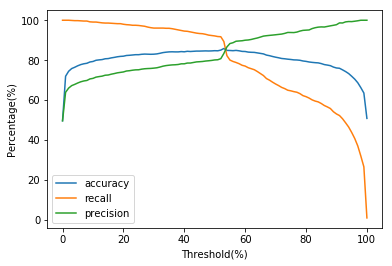

In [16]:
#---------------------------------------
#評価⑨
#---------------------------------------
model = load_model('temp_bestdl_model.h5') #暫定ベストモデルを読み込む
model.summary()
scores = model.evaluate(val_x, val_y, verbose=0,batch_size=512)
print("validation_acc:%.4f"%scores[1])

#再現率(recall)と適合率(precision)のトレードオフ確認
val_acc_list=[]
val_prec_list=[]
val_rec_list=[]
predicted_proba_validation_y = model.predict(val_x, batch_size=512)
for thres_p in range(101):
    # thres_pの閾値で予測した際のラベルを作成。
    pred_val_y = [1. if p >= thres_p/100. else 0. \
                  for p in predicted_proba_validation_y] 
    temp_cm = confusion_matrix(val_y, pred_val_y)
    
    val_acc = (temp_cm[0][0] + temp_cm[1][1])/np.sum(temp_cm) * 100.
    val_acc_list.append(val_acc) # 正解率をリストに追加
    val_perc = (temp_cm[1][1]) / (temp_cm[0][1] + temp_cm[1][1] + 1.e-18) * 100.
    val_prec_list.append(val_perc) # 適合率をリストに追加
    val_rec = (temp_cm[1][1]) / np.sum(temp_cm[1]) * 100.
    val_rec_list.append(val_rec) # 再現率をリストに追加
plt.plot(val_acc_list, label='accuracy')
plt.plot(val_rec_list, label='recall')  
plt.plot(val_prec_list, label='precision')  
plt.xlabel('Threshold(%)')
plt.ylabel('Percentage(%)')
plt.legend()  
plt.show()

#再現率（Recall）が99%となる閾値算出
for th in range(101):
    if val_rec_list[th] < 99.:
        break
th = np.max( [th-1., 0.] )

### ⑨－２：テストデータでの評価
まずは閾値を50%にしたときの結果を確認します。<br>
ここでは、混合行列で結果を出力していますが、必要に応じて正解率、再現率、適合率、F値などを計算してみましょう。

In [17]:
pred_proba_test_y = model.predict(test_x, batch_size=512)
# 閾値50%とした時の予測ラベル
pred_test_y = [1. if p >= 50./100. else 0. for p in pred_proba_test_y] 
temp_cm = confusion_matrix(test_y, pred_test_y)
print(temp_cm)

[[781 211]
 [105 903]]


検証データで再現率が99%になる閾値を用いてテストデータで評価します。<br>
ここでは、混合行列で結果を出力していますが、必要に応じて正解率、再現率、適合率、F値などを計算してみましょう。

In [18]:
# 再現率99%となるような閾値を使った時の予測ラベル
pred_test_y = [1. if p >= th/100. else 0. for p in pred_proba_test_y]
temp_cm = confusion_matrix(test_y, pred_test_y)
print(temp_cm)

[[612 380]
 [ 13 995]]
